In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import stanza
import re
import matplotlib.pyplot as plt

In [ ]:
stanza.download('en') # download English model

# Load Data

In [ ]:
with open('Data/News_Category_Dataset_IS_course.json') as f:
    lines = f.readlines()


In [ ]:
lines = [json.loads(line) for line in lines]

In [ ]:
lines[1:6]

In [6]:
# convert to pandas dataframe
df = pd.DataFrame(lines)

In [7]:
df.shape

(148122, 6)

In [8]:
# sort out datatypes
# date
df['date'] = pd.to_datetime(df['date'])
# headline
df['headline'] = df['headline'].astype(str)
# authors
df['authors'] = df['authors'].astype(str)
# link
df['link'] = df['link'].astype(str)
# short_description
df['short_description'] = df['short_description'].astype(str)
# category as a category
df['category'] = df['category'].astype('category')

In [9]:
# round date to nearest day
df['day'] = df['date'].dt.floor('d')
# huh only one unique date
df['day'].describe()

C:\Users\benjo\AppData\Local\Temp\ipykernel_2060\114677802.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df['day'].describe()


count                  148122
unique                      1
top       1970-01-01 00:00:00
freq                   148122
first     1970-01-01 00:00:00
last      1970-01-01 00:00:00
Name: day, dtype: object

In [10]:
df['date'].describe()

C:\Users\benjo\AppData\Local\Temp\ipykernel_2060\801468514.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df['date'].describe()


count                         148122
unique                          3618
top       1970-01-01 00:23:35.145600
freq                              98
first     1970-01-01 00:22:07.708800
last      1970-01-01 00:27:43.891200
Name: date, dtype: object

In [11]:
# turn date into time as all the same day
df['time'] = df['date'].dt.time

In [12]:
df['time'].describe()

count              148122
unique               3618
top       00:23:35.145600
freq                   98
Name: time, dtype: object

# Exploratory Data Analysis

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148122 entries, 0 to 148121
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               148122 non-null  object        
 1   headline           148122 non-null  object        
 2   category           148122 non-null  category      
 3   short_description  148122 non-null  object        
 4   authors            148122 non-null  object        
 5   date               148122 non-null  datetime64[ns]
 6   day                148122 non-null  datetime64[ns]
 7   time               148122 non-null  object        
dtypes: category(1), datetime64[ns](2), object(5)
memory usage: 8.1+ MB


## Missing values

In [14]:
# check for nas
df.isna().sum()

link                 0
headline             0
category             0
short_description    0
authors              0
date                 0
day                  0
time                 0
dtype: int64

In [15]:
# check for NULLs
df.isnull().sum()

link                 0
headline             0
category             0
short_description    0
authors              0
date                 0
day                  0
time                 0
dtype: int64

In [16]:
# look for empty strings across all columns
(df == '').sum()

link                     0
headline                 3
category                 0
short_description    11448
authors              24416
date                     0
day                      0
time                     0
dtype: int64

In [17]:
((df == '').sum()  / df.shape[0]) * 100

link                  0.000000
headline              0.002025
category              0.000000
short_description     7.728764
authors              16.483709
date                  0.000000
day                   0.000000
time                  0.000000
dtype: float64

In [18]:
print(df[(df['authors'] == '') & (df['short_description'] == '') & (df['headline'] == '')].shape[0])
print(df[(df['authors'] == '') & (df['short_description'] == '')].shape[0])


0
2245


In [19]:
df[df['headline'] == '']

,link,headline,category,short_description,authors,date,day,time
62046,https://www.huffingtonpost.com/entry/lincoln-2...,,POLITICS,,"Robert Moran, ContributorRobert Moran leads Br...",1970-01-01 00:24:00.201600,1970-01-01,00:24:00.201600
72619,https://www.huffingtonpost.com/entry/disney-ce...,,BUSINESS,,"Gary Snyder, ContributorWriter and Media Strat...",1970-01-01 00:23:42.144000,1970-01-01,00:23:42.144000
80016,https://www.huffingtonpost.com/entry/beverly-h...,,QUEER VOICES,,"Gary Snyder, ContributorWriter and Media Strat...",1970-01-01 00:23:29.184000,1970-01-01,00:23:29.184000


In [20]:
# remove observations with headline as empty string
df = df[df['headline'] != '']
# TODO: should we remove short_description as well if empty?
# df = df[df['short_description'] != '']
# TODO: what about authors?
# df = df[df['authors'] != '']

In [21]:
# TODO: for now I will just remove all observations with empty strings (missing values)
df = df[(df != '').all(1)]

Insights:
- There is missingness
- Mostly in Short description and Author (and sometimes both are missing)
- Only in 3 observations is there no headline and in all cases there is no short-description

### Category

In [22]:
df['category'].value_counts()

POLITICS          29693
ENTERTAINMENT     13476
WELLNESS          12944
TRAVEL             8027
STYLE & BEAUTY     7275
PARENTING          6520
HEALTHY LIVING     5079
QUEER VOICES       4705
FOOD & DRINK       4527
BUSINESS           4376
COMEDY             3938
SPORTS             3612
HOME & LIVING      3523
PARENTS            3492
BLACK VOICES       3316
Name: category, dtype: int64

Text(0.5, 1.0, 'Category Distribution')

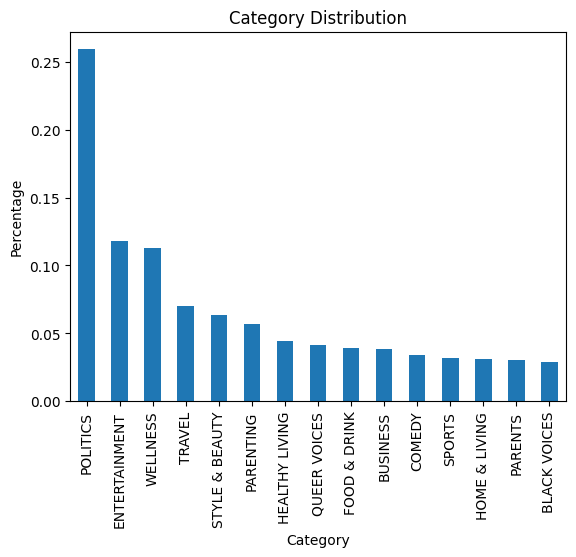

In [23]:
(df['category'].value_counts() / df.shape[0]).plot(kind='bar')
# add labels
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.title('Category Distribution')


### Authors

In [24]:
# unique authors count
len(df['authors'].unique())

19015

In [25]:
# Number of authors with less than 10 articles
(df['authors'].value_counts() < 10).sum() / df.shape[0] * 100

15.43977013702698

In [26]:
df['authors'].value_counts()[100:300]

The Daily Meal, Contributor\nAll things food and drink                                              180
Laura Bassett                                                                                       175
Christina Wilkie                                                                                    172
Rain Embuscado                                                                                      172
Mary Kincaid, Contributor\nFounder and Editor of Zuburbia.com                                       170
                                                                                                   ... 
Rick Hanson, Ph.D., Contributor\nPsychologist; Author, 'Hardwiring Happiness'                        43
Maureen Anderson, Contributor\nMaureen Anderson is the host of the nationally syndicated radi...     42
Andrew M. Seaman, Reuters                                                                            42
Marian Wright Edelman, ContributorPresident, Children's Defense 

In [27]:
df[df['authors'].str.len() > 100].head()


,link,headline,category,short_description,authors,date,day,time
11890,https://www.huffingtonpost.com/entry/research-...,Research Finds Hysterectomy Alone Associated W...,HEALTHY LIVING,Mayo Clinic researchers show that hysterectomy...,"Mayo Clinic Women's Health, ContributorOptimiz...",1970-01-01 00:25:15.024000,1970-01-01,00:25:15.024000
12099,https://www.huffingtonpost.com/entry/world-hea...,World Health Organization’s Junk Diagnosis For...,HEALTHY LIVING,News media reported this week that the World H...,"Christopher J. Ferguson, ContributorProfessor ...",1970-01-01 00:25:14.419200,1970-01-01,00:25:14.419200
12297,https://www.huffingtonpost.com/entry/first-us-...,First US Baby Born After Uterus Transplantatio...,HEALTHY LIVING,"A Texas woman recently gave birth to a boy, th...","Mayo Clinic Women's Health, ContributorOptimiz...",1970-01-01 00:25:13.814400,1970-01-01,00:25:13.814400
12429,https://www.huffingtonpost.com/entry/we-got-ar...,We Got Arrested To Show Senator Collins What W...,POLITICS,Being arrested in Collins' office didn’t scare...,"Jim Betts, Sarah Bigney, Tina Marie Davidson, ...",1970-01-01 00:25:13.641600,1970-01-01,00:25:13.641600
12612,https://www.huffingtonpost.com/entry/as-a-phys...,"As A Physician, Here's Why I Stand In Solidari...",POLITICS,Their fight must become ours as well.,"Aletha Maybank, MD, MPH, ContributorDeputy Com...",1970-01-01 00:25:13.296000,1970-01-01,00:25:13.296000


In [28]:
# look at the relationship between authors and category
# for top 100 authors
# get top 100 authors
top_100_authors = df['authors'].value_counts()[:100].index.tolist()
# look at the distribution of categories for each of these authors
df_top_100_authors = df[df['authors'].isin(top_100_authors)]
df_top_100_authors.groupby(['authors', 'category']).size()

authors                category      
Alana Horowitz Satlin  BLACK VOICES       2
                       BUSINESS          16
                       COMEDY             7
                       ENTERTAINMENT     10
                       FOOD & DRINK       0
                                         ..
Zeba Blay              QUEER VOICES       1
                       SPORTS             0
                       STYLE & BEAUTY     0
                       TRAVEL             0
                       WELLNESS           0
Length: 1500, dtype: int64

In [29]:
# for Elyse Wanshel get the distribution of categories
df[df['authors'] == 'Elyse Wanshel']['category'].value_counts()

ENTERTAINMENT     278
COMEDY             49
BLACK VOICES       39
POLITICS           23
QUEER VOICES       20
PARENTS            18
HEALTHY LIVING      6
SPORTS              4
TRAVEL              4
BUSINESS            1
STYLE & BEAUTY      1
WELLNESS            1
FOOD & DRINK        0
HOME & LIVING       0
PARENTING           0
Name: category, dtype: int64

<Axes: xlabel='authors'>

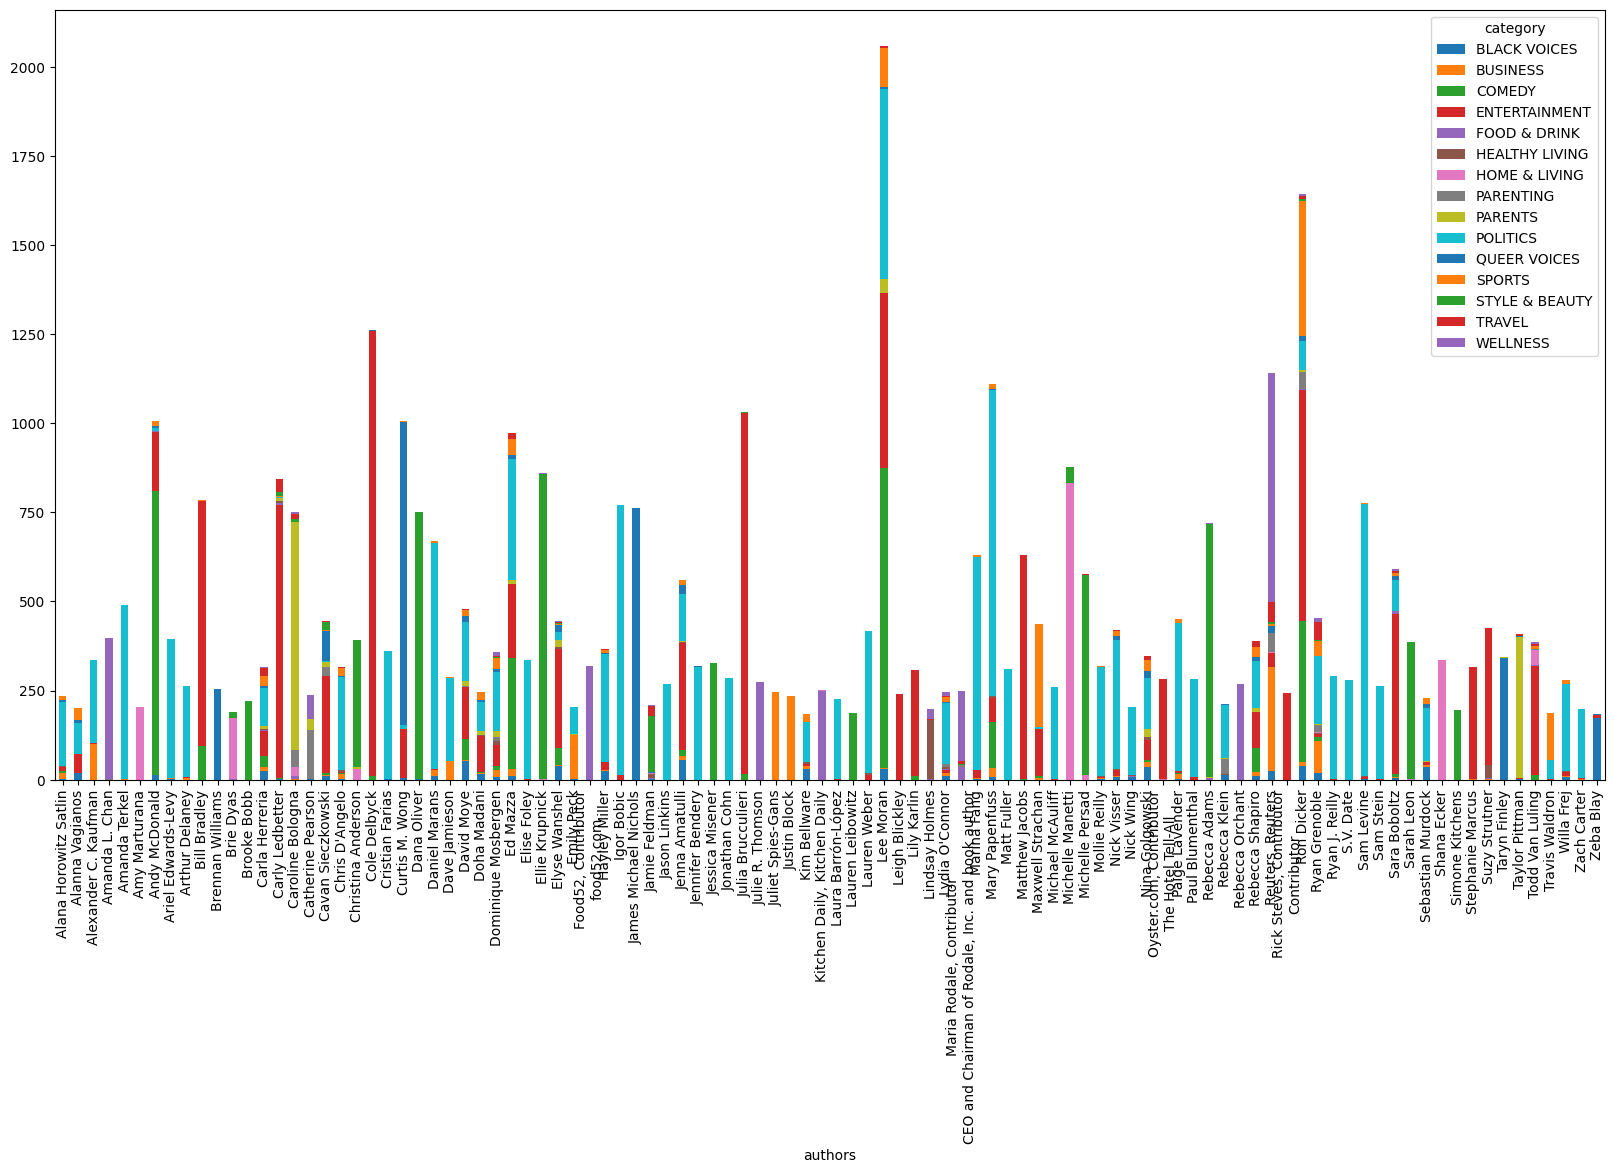

In [30]:
# plot the distribution of categories for top 100 authors
df_top_100_authors.groupby(['authors', 'category']).size().unstack().plot(kind='bar', stacked=True, figsize=(20, 10))

Insights:
- Some authors are just names whereas others have descriptions of the author
- Further some other authors are actually institutions rather than individuals
- There are a lot of authors that have more than one article in the dataset - almost 90% of authors have over 10 articles
- Author seems like it could be a useful predictor of Category
- There is a fair amount of missing data! How to resolve this!


### Link

In [31]:
# extract the website name from the link using regex
import re
df['website'] = df['link'].apply(lambda x: re.findall(r'(?<=www.)[^/]+', x)[0])

In [32]:
df['website'].unique().shape[0] / df.shape[0] * 100

0.001746679126311101

In [33]:
df['website'].value_counts()

huffingtonpost.com    109290
huffpost.com            5213
Name: website, dtype: int64

Insight:
- Link is not useful all links are from huffingtonpost - should've known that :(

### Date

Date looks a bit suspicious. All articles are from the same day and there are only 3618 unique times. Not sure if this will be a useful feature. And the data is not text format so maybe they don't want us to use for the assignment anyways. Also seems unlikely that time of day will be that useful for predicting category

# Data Wranling

In [34]:
# drop unnecessary features
# no date
df.drop(['date'], axis=1, inplace=True)
df.drop(['day'], axis=1, inplace=True)
df.drop(['time'], axis=1, inplace=True)
# no link
df.drop(['link'], axis=1, inplace=True)

In [35]:
df.columns

Index(['headline', 'category', 'short_description', 'authors', 'website'], dtype='object')

# Preprocessing

In [36]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

# Download necessary resources (if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize Lemmatizer and Stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\benjo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\benjo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\benjo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [37]:
# Function to preprocess text
def preprocess_text(text):
    # Tokenize the text into words
    words = word_tokenize(text.lower())  # Convert text to lowercase

    # Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    words = [word.translate(table) for word in words if word.isalpha()]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lemmatization
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    preprocessed_text = ' '.join(lemmatized_words)

    # Stemming (uncomment if you want to use stemming)
    # stemmed_words = [stemmer.stem(word) for word in words]
    # prprocessed_text = ' '.join(stemmed_words)

    return preprocessed_text

In [38]:
# Apply the function to preprocess the text
df['headline_clean'] = df['headline'].apply(preprocess_text)
df['short_description_clean'] = df['short_description'].apply(preprocess_text)

In [39]:
# pre-process authors as well
df['authors_clean'] = df['authors'].apply(preprocess_text)

In [40]:
df['headline'].head()

0    23 Of The Funniest Tweets About Cats And Dogs ...
1    The Funniest Tweets From Parents This Week (Se...
2    Maury Wills, Base-Stealing Shortstop For Dodge...
5    ‘Beautiful And Sad At The Same Time’: Ukrainia...
6    Las Vegas Aces Win First WNBA Title, Chelsea G...
Name: headline, dtype: object

In [41]:
df['headline_clean'].head()

0                          funniest tweet cat dog week
1                           funniest tweet parent week
2                       maury will shortstop dodger dy
5    beautiful sad time ukrainian cultural festival...
6    la vega ace win first wnba title chelsea gray ...
Name: headline_clean, dtype: object

In [42]:
df['short_description'].head()

0    "Until you have a dog you don't understand wha...
1    "Accidentally put grown-up toothpaste on my to...
2    Maury Wills, who helped the Los Angeles Dodger...
5    An annual celebration took on a different feel...
6    Las Vegas never had a professional sports cham...
Name: short_description, dtype: object

In [43]:
df['short_description_clean'].head()

0                           dog understand could eaten
1    accidentally put toothpaste toddler toothbrush...
2    maury will helped los angeles dodger win three...
5    annual celebration took different feel russia ...
6     la vega never professional sport champion sunday
Name: short_description_clean, dtype: object

In [44]:
df['authors'].head()

0         Elyse Wanshel
1      Caroline Bologna
2       Beth Harris, AP
5    Jonathan Nicholson
6    Pat Eaton-Robb, AP
Name: authors, dtype: object

In [45]:
df['authors_clean'].head()

0         elyse wanshel
1      caroline bologna
2        beth harris ap
5    jonathan nicholson
6                pat ap
Name: authors_clean, dtype: object

## Test and Training Split

In [46]:
df.columns

Index(['headline', 'category', 'short_description', 'authors', 'website',
       'headline_clean', 'short_description_clean', 'authors_clean'],
      dtype='object')

In [47]:
X_train, X_test, y_train, y_test = train_test_split(df[['headline', 
                                                        'headline_clean', 
                                                        'short_description', 
                                                        'short_description_clean', 
                                                        'authors', 
                                                        'authors_clean']], 
                                                    df['category'], 
                                                    test_size=0.2, 
                                                    random_state=42
)

# Text Vectorisation

### Chat-GPT which to use?

The choice between word embeddings and TF-IDF (Term Frequency-Inverse Document Frequency) for text vectorization depends on the nature of your NLP task and the characteristics of your data. Here are some considerations for each approach:
Word Embeddings:

    Semantic Relationships:
        Word embeddings capture semantic relationships between words. If your task involves understanding the meaning and context of words, phrases, or documents, word embeddings (such as Word2Vec, GloVe, or embeddings from pre-trained models like BERT) are often more suitable.

    Contextual Information:
        Word embeddings capture contextual information. They take into account the surrounding words in a sentence, which can be crucial for tasks like sentiment analysis, named entity recognition, and part-of-speech tagging.

    Dimensionality Reduction:
        Word embeddings usually result in lower-dimensional representations compared to TF-IDF. This can be beneficial if you have limited computational resources or if you're dealing with high-dimensional data.

    Pre-trained Models:
        If your dataset is not large enough for training high-quality embeddings, pre-trained embeddings (e.g., Word2Vec, GloVe, BERT) can be used. These embeddings are trained on massive corpora and capture rich semantic information.

TF-IDF:

    Bag-of-Words Representation:
        TF-IDF is suitable when you want a simple and efficient bag-of-words representation of your documents. It ignores the order and context of words but can be effective for tasks like text classification, document clustering, or information retrieval.

    Document Importance:
        TF-IDF emphasizes the importance of words in a document relative to their frequency across the entire corpus. This can be beneficial if you want to identify key terms or features that distinguish documents from each other.

    Interpretable Features:
        TF-IDF provides easily interpretable features. Each word is represented by a weight, and these weights indicate the importance of the word in the document.

    Sparse Representations:
        TF-IDF tends to produce sparse representations, which can be advantageous if your dataset is large and you want to conserve memory.

General Recommendations:

    Size of the Dataset:
        For small datasets, pre-trained word embeddings might provide better results since they have been trained on large corpora. For larger datasets, you can experiment with both approaches.

    Task Requirements:
        Consider the specific requirements of your NLP task. If semantic relationships and context are crucial, word embeddings may be more suitable. If you need a simple bag-of-words representation or want to emphasize document-level importance, TF-IDF might be appropriate.

    Experimentation:
        It's often a good idea to experiment with both approaches and evaluate their performance on your specific task. Some tasks may benefit more from one approach over the other.

In practice, it's not uncommon to try both word embeddings and TF-IDF and compare their performance to determine which one works best for a particular NLP task.

Seems to suggest TF-IDF might be appropriate

## TF-IDF Approach

In [54]:
X_train['short_description_clean'].head()

9515      got point someone take stand owner melbourne c...
47974     italy people willing walk half mile first thin...
10869                                                  went
96946     every parent child life altering disease proba...
120819    fact joint guideline infectious disease societ...
Name: short_description_clean, dtype: object

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Import required libraries
# Model building: Choose and train a classifier
vectorizer = TfidfVectorizer()  # Use TF-IDF vectorizer for text to numerical feature conversion


In [50]:
#TODO: Using all features in the TF-IDF vectorizer causes issues - think about this
# X_train_vec = vectorizer.fit_transform(X_train[['short_description_clean', 'headline_clean', 'authors_clean']])
# X_test_vec = vectorizer.transform(X_test[['short_description_clean', 'headline_clean', 'authors_clean']])

In [51]:
# X_train_vec = vectorizer.fit_transform(X_train['short_description_clean'])
# X_test_vec = vectorizer.transform(X_test['short_description_clean'])

In [52]:
# X_train_vec = vectorizer.fit_transform(X_train['headline_clean'])
# X_test_vec = vectorizer.transform(X_test['headline_clean'])

In [53]:
X_train_vec = vectorizer.fit_transform(X_train['authors_clean'])
X_test_vec = vectorizer.transform(X_test['authors_clean'])

In [56]:
# attempt to merge features
X_train_vec = vectorizer.fit_transform(X_train['headline_clean'] + ' ' + X_train['short_description_clean'] + ' ' + X_train['authors_clean'])
X_test_vec = vectorizer.transform(X_test['headline_clean'] + ' ' + X_test['short_description_clean'] + ' ' + X_test['authors_clean'])

#### Basic Classification Methods

##### Logistic Regression

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000) # increase iterations to help with convergence (default is 100)
logistic_model.fit(X_train_vec, y_train)
logistic_predictions = logistic_model.predict(X_test_vec)
logistic_accuracy = accuracy_score(y_test, logistic_predictions)
print("Logistic Regression Accuracy:", logistic_accuracy)
#TODO: Investgate ConvergenceWarning

Logistic Regression Accuracy: 0.8538055106763897


In [82]:
# Classification metrics
from sklearn.metrics import classification_report
print(classification_report(y_test, logistic_predictions))

                precision    recall  f1-score   support

  BLACK VOICES       0.86      0.57      0.69       694
      BUSINESS       0.79      0.68      0.73       876
        COMEDY       0.78      0.60      0.68       783
 ENTERTAINMENT       0.83      0.87      0.85      2760
  FOOD & DRINK       0.91      0.87      0.89       926
HEALTHY LIVING       0.76      0.68      0.72       989
 HOME & LIVING       0.95      0.83      0.89       657
     PARENTING       0.82      0.81      0.81      1269
       PARENTS       0.86      0.73      0.79       734
      POLITICS       0.86      0.96      0.91      5995
  QUEER VOICES       0.89      0.77      0.83       909
        SPORTS       0.85      0.78      0.82       726
STYLE & BEAUTY       0.93      0.91      0.92      1453
        TRAVEL       0.90      0.91      0.91      1587
      WELLNESS       0.82      0.92      0.87      2543

      accuracy                           0.85     22901
     macro avg       0.86      0.79      0.82 

Performance:
- 0.59 accuracy for Short-description only model
- 0.69 accuracy for headline only model
- 0.78 accuracy for authors only model
- 0.85 accuracy for all features merged model
- ~0.25 accuracy for majority classifer


Text(0, 0.5, 'True Positive Rate')

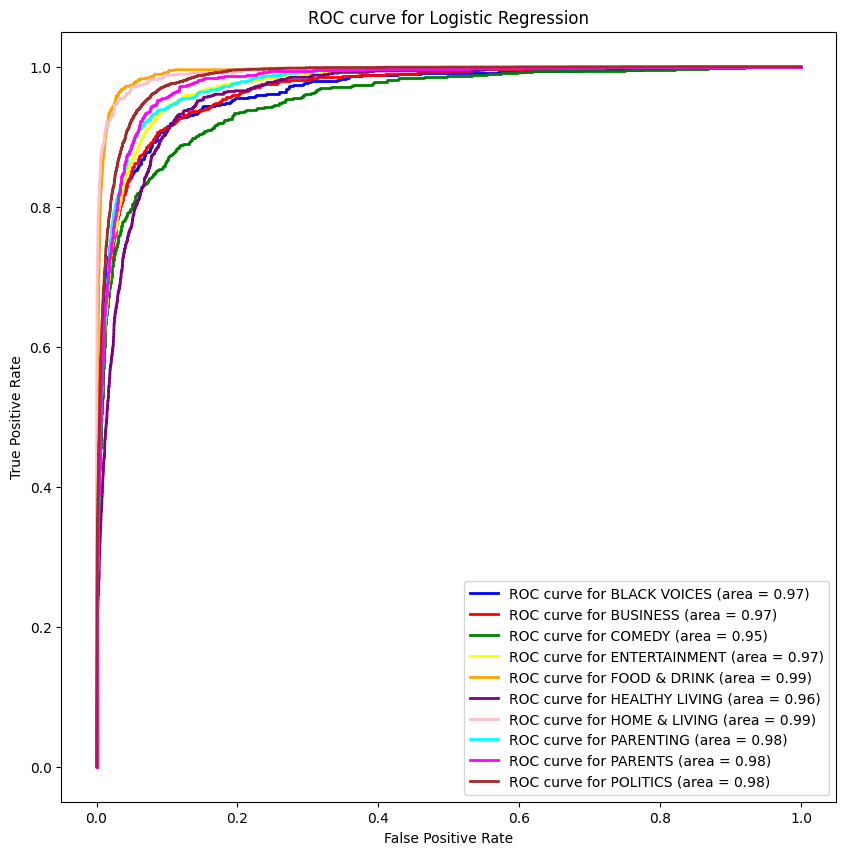

In [62]:
# ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
# plot the ROC curve
y_test_bin = label_binarize(y_test, classes=logistic_model.classes_)
y_score = logistic_model.decision_function(X_test_vec)
n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# plot the curves
plt.figure(figsize=(10, 10))
colors = ['blue', 'red', 'green', 'yellow', 'orange', 'purple', 'pink', 'cyan', 'magenta', 'brown']
for (idx, color) in zip(range(n_classes), colors):
    plt.plot(fpr[idx], tpr[idx], color=color, lw=2, label='ROC curve for {} (area = {:.2f})'.format(logistic_model.classes_[idx], roc_auc[idx]))
# add legend
plt.legend(loc='lower right')
# add title and axis labels
plt.title('ROC curve for Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [81]:
# hyper-parameter tuning
# C (inverse regularization strength) hyper-parameter tuning
# penalty (type of regularization) hyper-parameter tuning
# solver (optimization algorithm) hyper-parameter tuning
# class_weight (class imbalance) hyper-parameter tuning
# max_iter (maximum number of iterations) hyper-parameter tuning

# TODO: This doesn't work at the moment - most fits fail
# for now just do C and penalty
# from sklearn.model_selection import GridSearchCV
# # define the grid
# grid = dict()
# grid['C'] = [0.01, 0.1, 1.0]
# grid['penalty'] = ['l1', 'l2', 'elasticnet']
# # define the grid search
# search = GridSearchCV(logistic_model, grid, scoring='accuracy', cv=5, n_jobs=-1)
# # perform the search
# results = search.fit(X_train_vec, y_train)
# # summarize
# print('Mean Accuracy: %.3f' % results.best_score_)
# print('Config: %s' % results.best_params_)

c:\Users\benjo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\benjo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\benjo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\benjo\AppData\Local\Programs\Python\Python310\lib\site-package

Mean Accuracy: 0.843
Config: {'C': 1.0, 'penalty': 'l2'}


##### KNN

In [71]:
# kNN model
# TODO: cross-validation to find the best k
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_vec, y_train)
knn_predictions = knn_model.predict(X_test_vec)
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("kNN Accuracy:", knn_accuracy)

kNN Accuracy: 0.7695297148596131


Performance:
- 0.77 for all feautures merged model

##### Naive Bayes

In [72]:
# Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)
nb_predictions = nb_model.predict(X_test_vec)
nb_accuracy = accuracy_score(y_test, nb_predictions)
print("Naive Bayes Accuracy:", nb_accuracy)

Naive Bayes Accuracy: 0.6559975546919349


Performance:
- 0.66 for all features model

##### SVM

In [73]:
# SVM model
from sklearn.svm import SVC
svm_model = SVC() # default kernel is rbf and default C is 1.0
# TODO: cross-validation to find the best C and kernel
svm_model.fit(X_train_vec, y_train)
svm_predictions = svm_model.predict(X_test_vec)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)

I gave up after 10 minutes :(

Performance:
- for all features model

##### Bagging

Attempting to do Random forest (a bagging method)

In [ ]:
# Random Forest model
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train_vec, y_train)
rf_predictions = rf_model.predict(X_test_vec)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest Accuracy:", rf_accuracy)

Performance:
- ??? for all features model

##### Boosting

Attempting Gradient Boosting classification (a boosting method)

In [ ]:
# Gradient Boosting model
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train_vec, y_train)
gb_predictions = gb_model.predict(X_test_vec)
gb_accuracy = accuracy_score(y_test, gb_predictions)
print("Gradient Boosting Accuracy:", gb_accuracy)

Performance:
- ??? for all features model

##### Neural Network

I didn't pay attention in the lab (let's see what chat has got)

In [ ]:
# Neural Network model
from sklearn.neural_network import MLPClassifier
nn_model = MLPClassifier()
nn_model.fit(X_train_vec, y_train)
nn_predictions = nn_model.predict(X_test_vec)
nn_accuracy = accuracy_score(y_test, nn_predictions)
print("Neural Network Accuracy:", nn_accuracy)

Performance:
- ??? all features model

## Word Embeddings Approach